# Importance sampling


We want to estimate the following integral:

$$ \int_0^{\pi/2} \sin(x) dx $$

Using first a crude Monte Carlo approximation and then using the importance sampling method using the family of functions as sampling functions:

$$ g_{a,b}(x) = a+ bx^2 $$

We start by evaluating the integral analytically:

$$ \int_0^{\pi/2} \sin(x) dx = 1$$

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import numba

### Crude Monte Carlo

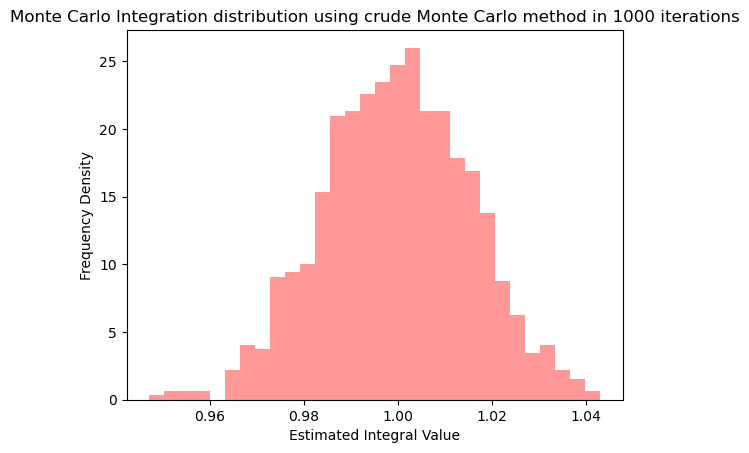

In [3]:
@numba.njit
def integrandFunction (x):
    return np.sin(x)

iterations = 1000
random.seed()

@numba.njit
def crudeMonteCarlo (iterations):
    sum = 0
    for _ in range(iterations):
        sum += integrandFunction(np.random.uniform(0,np.pi/2))
    return (np.pi/2 -0 ) * sum/iterations    

generated_points=1000
crude_mc_distribution=np.zeros(generated_points)

for i in range (generated_points):
    crude_mc_distribution[i]=crudeMonteCarlo(iterations)

plt.hist(crude_mc_distribution, bins=30, density=True, alpha=0.4, color='r')
plt.xlabel("Estimated Integral Value")
plt.ylabel("Frequency Density")
plt.title(f"Monte Carlo Integration distribution using crude Monte Carlo method in {iterations} iterations")
plt.show()

### Importance Sampling method

We first make some consideration on the family of functions $g_{a,b}(x)$.
First we impose, as they must be PDF's, the normalization condition on $[0, \pi/2]$, so that we obtain the constraint:

$$ b = \frac{24}{\pi^3} - \frac{12 a}{\pi^2} $$

In this way $g_{a,b}(x)$ collapses to a one parameter family:

$$ g_{a}(x) = a+ \left( \frac{24}{\pi^3} - \frac{12 a}{\pi^2} \right) x^2 $$

Moreover if we impose the condition $g_{a}(x) > 0$ we obtain for $a$ the restriction $ 0 < a < \frac{2}{\pi} $. Finally in order to fix $a$ we impose that the maximum of $g$ coincides with the maximum of $f$

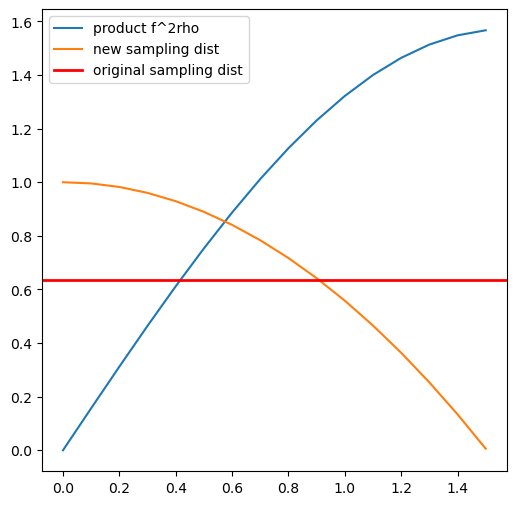

In [ ]:
# Choosing the parameter a

a=1/np.pi

b = 24/np.pi**3 -(12 *a)/np.pi**2

@numba.njit
def samplingFunction (x):
    return a + (b * x**2)

def original_sampling_function (x):
    return 1/(np.pi/2)

x = np.arange(0, np.pi/2, 0.1)

function_squared = integrandFunction(x)/original_sampling_function(x)
original_sampling=original_sampling_function(x)
new_sampling=samplingFunction(x)

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot (x,function_squared, label="product f^2rho")
plt.plot(x, new_sampling, label= "new sampling dist")
ax.axhline(y=2/np.pi, color='red', linestyle='-', linewidth=2, label="original sampling dist")
plt.legend()
plt.show()


Now we simply proceed with the method:
We want to use the rejection sample to sample from $g(x)$, so we want to find the appropriate dominant 
function.

**An important note** you should not expect truncated distribution to have the same PDF except on a shorter interval — this is plain impossible because the area under the graph of a PDF is always 1, so they we'll not be normalized.


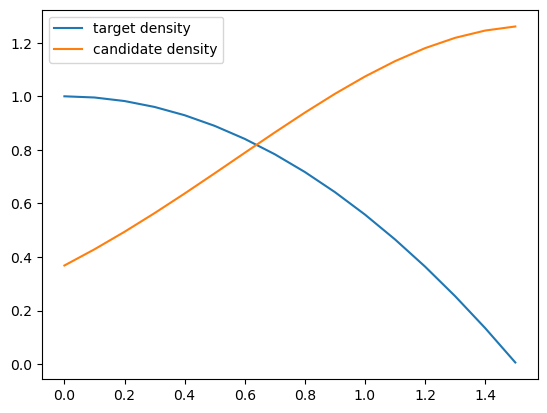

In [5]:
mean = np.pi/2
sigma = 1
c = 1.4

def truncated_normal (x ,left_t, right_t):
    return stats.norm.pdf(x, mean, sigma) / (stats.norm.cdf(right_t)-stats.norm.cdf(left_t))

plt.plot (x, new_sampling , label = "target density")
plt.plot (x, c * truncated_normal (x, 0, np.pi/2)  ,label = "candidate density")

plt.legend()
plt.show()

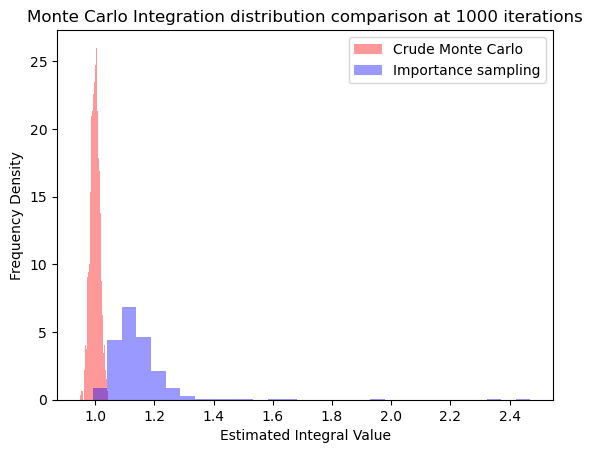

In [6]:
numberSampledPoints = 2000
loc=mean
scale=sigma
a_trunc=0
b_trunc=np.pi/2

a1, b1 = (a_trunc - loc) / scale, (b_trunc - loc) / scale

def importance_sampling_mc (numberSampledPoints):
    total_sum = 0
    counter = 0
    while counter < numberSampledPoints:
        randomVariable = stats.truncnorm.rvs(a1,b1, loc=mean, scale=sigma)
        uniformRandomNum = random.random()
        acceptance_threshold = samplingFunction(randomVariable) / (c * truncated_normal(randomVariable, a_trunc,b_trunc) )
        if uniformRandomNum <= acceptance_threshold:
            total_sum+=integrandFunction(randomVariable)/samplingFunction(randomVariable)
            counter+=1
    return total_sum/counter       

imp_mc_distribution=np.zeros(generated_points)

for i in range (generated_points):
    imp_mc_distribution[i]=importance_sampling_mc(iterations)

plt.hist(crude_mc_distribution, bins=30, density=True, alpha=0.4, color='r', label= "Crude Monte Carlo")
plt.hist(imp_mc_distribution, bins=30, density=True, alpha=0.4, color='b', label="Importance sampling")
plt.xlabel("Estimated Integral Value")
plt.ylabel("Frequency Density")
plt.title(f"Monte Carlo Integration distribution comparison at {iterations} iterations")
plt.legend()
plt.show()


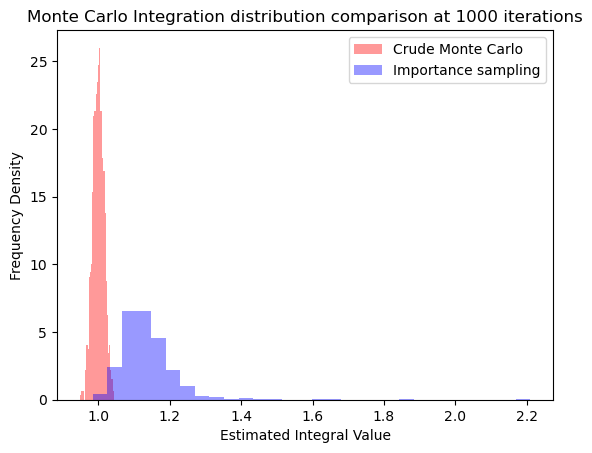

In [7]:
def importance_sampling_mc_vectorized(numberSampledPoints):
    total_sum = 0
    batch_size = 10 * numberSampledPoints 
    randomVariables = stats.truncnorm.rvs(a1, b1, loc=mean, scale=sigma, size=batch_size)
    acceptance_thresholds = samplingFunction(randomVariables) / (c * truncated_normal(randomVariables, a_trunc, b_trunc))       
    uniformRandomNums = np.random.random(batch_size)
    accepted_indices = uniformRandomNums <= acceptance_thresholds # boolean indexing of uniform_random_numbers
    accepted_samples = randomVariables[accepted_indices]
    accepted_samples = accepted_samples[accepted_samples != 0] # remove extra zeros
    if len(accepted_samples) > numberSampledPoints:
        accepted_samples = accepted_samples[:numberSampledPoints] 
    total_sum = np.sum(integrandFunction(accepted_samples) / samplingFunction(accepted_samples))                
    return total_sum / numberSampledPoints

imp_mc_distribution=np.zeros(generated_points)

for i in range (generated_points):
    imp_mc_distribution[i]=importance_sampling_mc_vectorized(iterations)

plt.hist(crude_mc_distribution, bins=30, density=True, alpha=0.4, color='r', label= "Crude Monte Carlo")
plt.hist(imp_mc_distribution, bins=30, density=True, alpha=0.4, color='b', label="Importance sampling")
plt.xlabel("Estimated Integral Value")
plt.ylabel("Frequency Density")
plt.title(f"Monte Carlo Integration distribution comparison at {iterations} iterations")
plt.legend()
plt.show()    

2. Let us compute the average

$$\langle f\rangle_\rho=\int_{\mathbb{R}}f(x)\rho(x)dx$$

where $\rho\in\mathcal{N}(0,1)$ and

$$f(x)=e^{-(x-3)^2/2}+e^{-(x-6)^2/2}$$

(a) Show that $\langle f\rangle_\rho$ can be computed in closed form and derive its value.

(b) Construct a regular Monte Carlo approximation based on a normal distribution $\mathcal{N}(0,1)$ by sampling

$N=10^3$ points and estimate the corresponding error.

(c) Compare the above result with the one obtained using the importance sampling approximation based on the uniform distribution $ g\in U[-8,-1]. Use again $N=10^3$ samples

we have that :

$$\langle f \rangle = \frac{1 + e^{27/4}}{\sqrt{2} e^9} \simeq 0.075$$

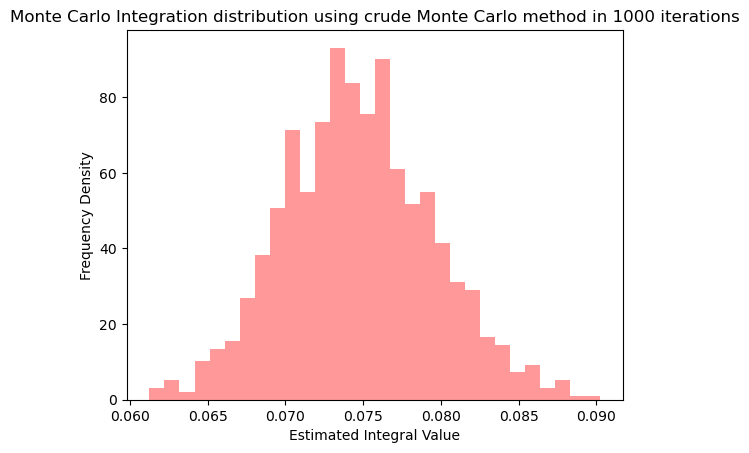

In [8]:
@numba.njit
def integration_function(x):
    return np.exp(-(x - 3)**2 /2) + np.exp(-(x - 6)**2 /2)

iterations = 1000
random.seed()

@numba.njit
def crudeMonteCarlo (iterations):
    sum = 0
    for _ in range(iterations):
        sum += integration_function(np.random.normal(0,1))
    return sum / iterations    

generated_points=1000
crude_mc_distribution=np.zeros(generated_points)

for i in range (generated_points):
    crude_mc_distribution[i]=crudeMonteCarlo(iterations)

plt.hist(crude_mc_distribution, bins=30, density=True, alpha=0.4, color='r')
plt.xlabel("Estimated Integral Value")
plt.ylabel("Frequency Density")
plt.title(f"Monte Carlo Integration distribution using crude Monte Carlo method in {iterations} iterations")
plt.show()



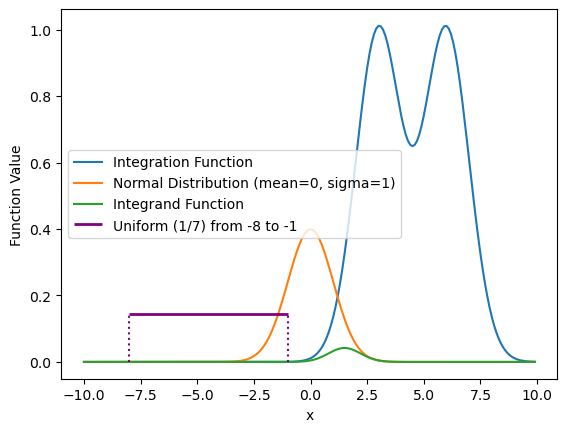

In [9]:
# Define x range and evaluate integration_function
x = np.arange(-10, 10, 0.1)
y = integration_function(x)  # Assuming integration_function is defined

# Plot the integration function and other lines
plt.plot(x, y, label="Integration Function")
plt.plot(x, stats.norm.pdf(x, 0, 1), label="Normal Distribution (mean=0, sigma=1)")
plt.plot(x, integration_function(x) * stats.norm.pdf(x, 0, 1), label="Integrand Function")

# Plot the line from -8 to -1 at height 1/7
plt.hlines(1/7, -8, -1, color='purple', linestyle='-', linewidth=2, label="Uniform (1/7) from -8 to -1")

# Add dotted lines from -8 and -1 to the x-axis
plt.vlines([-8, -1], ymin=0, ymax=1/7, color='purple', linestyle='dotted')

# Show legend and labels
plt.xlabel("x")
plt.ylabel("Function Value")
plt.legend()
plt.show()

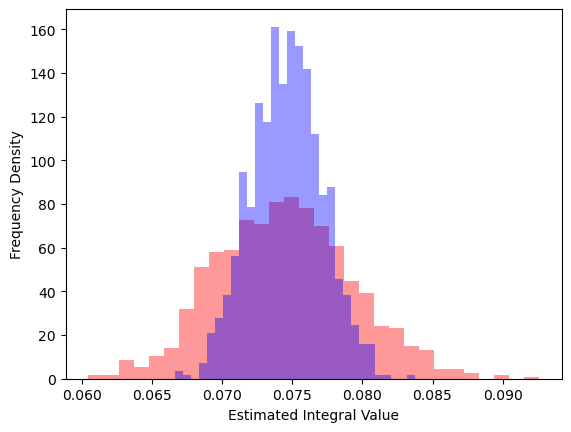

In [10]:
@numba.njit
def normal_distribution(x, mean, sigma):
    return 1.0 / (sigma * np.sqrt(2.0 * np.pi)) * np.exp(-(x - mean)**2 / 2.0)

@numba.njit
def importanceMonteCarlo (iterations):
    sum = 0
    for _ in range(iterations):
        tmp = np.random.uniform(-1, 4.5)
        sum += (integration_function(tmp) * normal_distribution(tmp, 0, 1)) / (1/(5.5)) 
    return sum / iterations    

generated_points=1000
importance_mc_distribution=np.zeros(generated_points)

for i in range (generated_points):
    crude_mc_distribution[i]=crudeMonteCarlo(iterations)
    importance_mc_distribution[i]=importanceMonteCarlo(iterations)

plt.hist(crude_mc_distribution, bins=30, density=True, alpha=0.4, color='r')
plt.hist(importance_mc_distribution, bins=30, density=True, alpha=0.4, color='b')
plt.xlabel("Estimated Integral Value")
plt.ylabel("Frequency Density")
#plt.title(f"Monte Carlo Integration distribution using crude Monte Carlo method in {iterations} iterations")
plt.show()
